In [12]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Configuration

In [13]:
# =========================
# PATHS & DATA SETTINGS
# =========================
DATA_DIR = r"C:\Users\joelj\CHALMERS\Exchange\Intelligent Systems\Individual Project\Data\SHM-Data"
FREQUENCY = "100kHz"
FILENAME = f"pc_f{FREQUENCY}.h5"

BASELINE_IDS = [10, 20, 30, 40, 50]
DAMAGE_IDS   = [1, 6, 11, 16, 21]

# =========================
# SIGNAL PROCESSING
# =========================
FS = 1_000_000        # sampling frequency (adjust if needed)
NPERSEG = 256
NOVERLAP = 128

# =========================
# TRAINING
# =========================
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Data handling and spectrogram conversion

In [14]:
def load_h5_file(filepath):
    with h5py.File(filepath, "r") as f:
        signals = f["pitchcatch/catch"][:]  # (66, signal_length)
    return signals

def compute_spectrogram(signal):
    f, t, Sxx = spectrogram(
        signal,
        fs=FS,
        nperseg=NPERSEG,
        noverlap=NOVERLAP,
        mode="magnitude"
    )
    return Sxx

def collect_data():
    X, y = [], []

    # Healthy
    for bid in BASELINE_IDS:
        pattern = os.path.join(DATA_DIR, f"*baseline_{bid}*", FILENAME)
        for filepath in glob.glob(pattern):
            signals = load_h5_file(filepath)
            for sig in signals:
                S = compute_spectrogram(sig)
                X.append(S)
                y.append(0)

    # Damaged
    for did in DAMAGE_IDS:
        pattern = os.path.join(DATA_DIR, f"*D{did}*", FILENAME)
        for filepath in glob.glob(pattern):
            signals = load_h5_file(filepath)
            for sig in signals:
                S = compute_spectrogram(sig)
                X.append(S)
                y.append(1)

    X = np.array(X)
    y = np.array(y)

    # Log scaling
    X = np.log10(X + 1e-10)

    # Per-sample normalization
    X = (X - X.mean(axis=(1,2), keepdims=True)) / (
        X.std(axis=(1,2), keepdims=True) + 1e-6
    )

    return X, y

class SHMSpectrogramDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    


Load data

In [15]:
# Load data
X, y = collect_data()
print("Data shape:", X.shape)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

train_ds = SHMSpectrogramDataset(X_train, y_train)
test_ds  = SHMSpectrogramDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

Data shape: (792, 129, 101)


Visualization

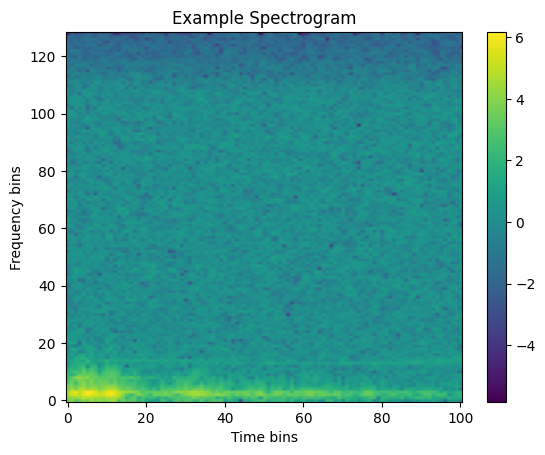

In [16]:
plt.imshow(X[0], aspect="auto", origin="lower")
plt.title("Example Spectrogram")
plt.xlabel("Time bins")
plt.ylabel("Frequency bins")
plt.colorbar()
plt.show()

CNN model

In [17]:
class CNN2D(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Infer FC size automatically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, *input_shape)
            n_features = self.conv(dummy).view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


Model

In [18]:
model = CNN2D(input_shape=X.shape[1:]).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

Training

In [19]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10 | Loss: 0.7926
Epoch 2/10 | Loss: 0.6851
Epoch 3/10 | Loss: 0.6759
Epoch 4/10 | Loss: 0.6745
Epoch 5/10 | Loss: 0.6747
Epoch 6/10 | Loss: 0.6546
Epoch 7/10 | Loss: 0.5787
Epoch 8/10 | Loss: 0.4144
Epoch 9/10 | Loss: 0.2288
Epoch 10/10 | Loss: 0.0947


Evaluation

In [20]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb)
        preds = torch.argmax(out, dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(yb.numpy())

print(classification_report(
    y_true, y_pred,
    target_names=["Healthy", "Damaged"]
))


              precision    recall  f1-score   support

     Healthy       0.58      0.73      0.65        83
     Damaged       0.76      0.62      0.68       115

    accuracy                           0.67       198
   macro avg       0.67      0.68      0.67       198
weighted avg       0.69      0.67      0.67       198



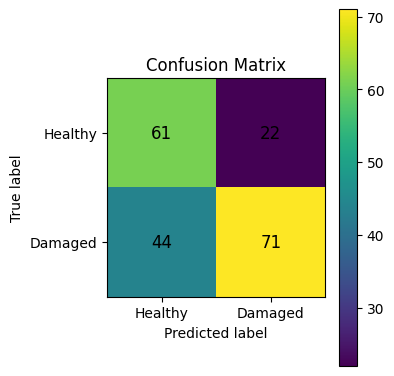

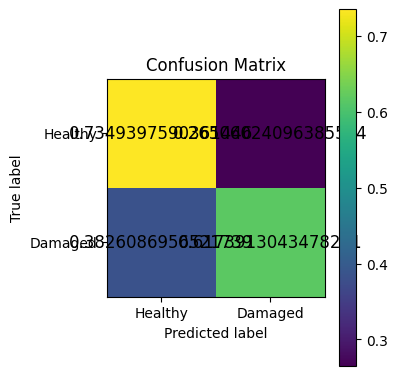

In [21]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.xticks(range(len(class_names)), class_names)
    plt.yticks(range(len(class_names)), class_names)

    # Print numbers in each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, cm[i, j],
                ha="center", va="center",
                fontsize=12
            )

    plt.colorbar()
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(
    cm,
    class_names=["Healthy", "Damaged"]
)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plot_confusion_matrix(
    cm_norm,
    class_names=["Healthy", "Damaged"]
)


